# 2x2 MMI power splitter

**Note: this notebook is 90% AI-generated.**

In this notebook, we will design and simulate a 2x2 Multi-Mode Interference (MMI) power splitter for photonic integrated circuits (PICs). The MMI power splitter is a fundamental component in integrated photonics, providing equal power splitting (50/50) with high efficiency.

The design follows standard Silicon-on-Insulator (SOI) platform specifications with cosine S-bends for optimal performance. We will demonstrate the complete simulation workflow including geometry setup and performance evaluation.

For more integrated photonic examples such as the 8-Channel mode and polarization demultiplexer, the broadband bi-level taper polarization rotator-splitter, and the broadband directional coupler, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101 tutorials](https://www.flexcompute.com/tidy3d/learning-center/fdtd-101/).

FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/learning-center/troubleshooting/) to resolve it.

<img src="./img/mmi_power_splitter_2x2.png" alt="Schematic of the 2x2 MMI Power Splitter"  width="400"/>


## Standard Python Imports

We start by importing the necessary libraries for our simulation.


In [1]:
# Standard python imports.
import gdstk
import matplotlib.pylab as plt
import numpy as np

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

## MMI Power Splitter Structure

The 2x2 MMI power splitter is based on a standard Silicon-on-Insulator (SOI) wafer with a device layer of 220 nm. The MMI section provides multimode interference for equal power splitting, while cosine S-bends route the input/output signals to offset positions for practical device integration.

**Key Design Parameters:**
- *Material Platform*: Silicon-on-Insulator (SOI)
- *Wavelength Range*: 1.5 to 1.6 μm (telecom C-band)
- *Design Goal*: Equal power splitting (50/50)

The MMI length is designed to achieve optimal interference patterns for equal power splitting around 1.55 micrometers, while the S-bends provide smooth transitions to offset input/output waveguides.


In [2]:
# MMI power splitter setup.
wavelength = 1.55  # Center simulation wavelength (um).
freq0 = td.C_0 / wavelength  # Central frequency.

In [3]:
# Materials.
n_si = 3.48  # Silicon refractive index.
n_sio2 = 1.44  # SiO2 refractive index.

# Material definitions.
mat_si = td.Medium(permittivity=n_si**2)  # Silicon waveguide material.
mat_sio2 = td.Medium(permittivity=n_sio2**2)  # SiO2 substrate material.

In [4]:
# This cell contains all the geometry, sources, monitors, and simulation creation

# MMI power splitter dimensions.
w_wg = 0.4  # Waveguide width (um).
h_si = 0.22  # Silicon layer height (um).
w_mmi = 1.0  # MMI section width (um).
l_mmi = 3.0  # MMI section length (um).
gap = 0.2  # Gap between output waveguides (um).

# Waveguide lengths.
l_input = 2.0  # Input waveguide length (um).
l_output = 3.0  # Output waveguide length (um).

# S-bend parameters.
s_bend_offset = 1.0  # Lateral offset for S-bends (um).
s_bend_length = 4.0  # Length of S-bend section (um).

## Cosine S-bend Function

We define a cosine S-bend function for smooth waveguide transitions. This function creates high-quality S-bends that minimize insertion loss.


In [5]:
# Function to create cosine S-bends.
def cosine_sbend(
    x0,
    y0,
    z0,
    wg_width,
    wg_thickness,
    bend_length,
    bend_height,
    medium,
    orientation="x",
    mirror=False,
    sidewall_angle=0,
):
    """Cosine S-bend function for smooth waveguide transitions."""
    cell = gdstk.Cell("bend")
    path = gdstk.RobustPath((x0, y0), wg_width, layer=1, datatype=0)

    if orientation == "x":
        path.segment(
            (x0 + bend_length, y0),
            offset=lambda u: -bend_height * np.cos(np.pi * u) / 2 + bend_height / 2,
        )
        if mirror:
            path.mirror((x0 + 1, y0), (x0, y0))
    elif orientation == "y":
        path.segment(
            (x0, y0 + bend_length),
            offset=lambda u: -bend_height * np.cos(np.pi * u) / 2 + bend_height / 2,
        )
        if mirror:
            path.mirror((x0, y0 + 1), (x0, y0))

    cell.add(path)
    bend_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )
    return td.Structure(geometry=bend_geo[0], medium=medium)

## Complete MMI Power Splitter Simulation Setup

Now we create the complete 2x2 MMI power splitter simulation with x-axis propagation. The simulation includes the MMI section, input/output waveguides, cosine S-bends, sources, and monitors.


In [6]:
# Calculate optimized simulation domain size for x-axis propagation.
x_min = -1.5 - 3.0  # -4.5 um
x_max = 5.5 + 3.0  # 8.5 um
total_length = x_max - x_min  # 13.0 um
total_width = w_mmi + 4.0  # Keep width buffer for offset waveguides
total_height = 2.0  # Sufficient for SOI structure
sim_size_optimized = (total_length, total_width, total_height)

# 1. MMI section (main multimode interference region).
mmi_section = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(l_mmi, w_mmi, h_si)), medium=mat_si
)

# 2. Output S-bend 1.
output_s_bend_1 = cosine_sbend(
    x0=l_mmi / 2,  # Start at MMI right edge (x-axis propagation)
    y0=w_wg / 2 + gap / 2,  # Start at MMI top edge
    z0=0,
    wg_width=w_wg,
    wg_thickness=h_si,
    bend_length=s_bend_length,
    bend_height=s_bend_offset,
    medium=mat_si,
    orientation="x",
    mirror=False,
)

# 3. Output waveguide 1.
output_wg_1 = td.Structure(
    geometry=td.Box(
        center=(l_mmi / 2 + s_bend_length + l_output / 2, w_wg / 2 + gap / 2 + s_bend_offset, 0),
        size=(l_output, w_wg, h_si),
    ),
    medium=mat_si,
)

# 4. Output S-bend 2.
output_s_bend_2 = cosine_sbend(
    x0=l_mmi / 2,  # Start at MMI right edge (x-axis propagation)
    y0=-w_wg / 2 - gap / 2,  # Start at MMI bottom edge
    z0=0,
    wg_width=w_wg,
    wg_thickness=h_si,
    bend_length=s_bend_length,
    bend_height=-s_bend_offset,
    medium=mat_si,
    orientation="x",
    mirror=False,
)

# 5. Output waveguide 2.
output_wg_2 = td.Structure(
    geometry=td.Box(
        center=(l_mmi / 2 + s_bend_length + l_output / 2, -w_wg / 2 - gap / 2 - s_bend_offset, 0),
        size=(l_output, w_wg, h_si),
    ),
    medium=mat_si,
)

# 6. Create input waveguides using Tidy3D reflection transformation for x-axis propagation.
input_wg_1_geometry = output_wg_1.geometry.reflected(normal=(1, 0, 0))
input_wg_1 = td.Structure(geometry=input_wg_1_geometry, medium=mat_si)
input_wg_2_geometry = output_wg_2.geometry.reflected(normal=(1, 0, 0))
input_wg_2 = td.Structure(geometry=input_wg_2_geometry, medium=mat_si)
input_s_bend_1_geometry = output_s_bend_1.geometry.reflected(normal=(1, 0, 0))
input_s_bend_1 = td.Structure(geometry=input_s_bend_1_geometry, medium=mat_si)
input_s_bend_2_geometry = output_s_bend_2.geometry.reflected(normal=(1, 0, 0))
input_s_bend_2 = td.Structure(geometry=input_s_bend_2_geometry, medium=mat_si)

# 7. Combine all structures.
mmi_structures = [
    input_s_bend_1,
    input_wg_1,
    input_s_bend_2,
    input_wg_2,
    mmi_section,
    output_s_bend_1,
    output_wg_1,
    output_s_bend_2,
    output_wg_2,
]

# 8. Create frequency array for wavelength sweep.
wavelengths = np.arange(1.5, 1.61, 0.01)  # 1.5 to 1.6 μm with 10 nm steps
frequencies = td.C_0 / wavelengths

# 9. Mode source at the upper input waveguide (x-axis propagation).
source_position = (-6, 1.3, 0)
source_size = (0, 6 * w_wg, 6 * h_si)
mode_source = td.ModeSource(
    center=source_position,
    size=source_size,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1),
    mode_index=0,
)

# 10. Mode monitors at the output waveguides (x-axis propagation).
monitor_1_position = (l_mmi / 2 + s_bend_length + 0.5, w_wg / 2 + gap / 2 + s_bend_offset, 0)
monitor_1_size = (0, 6 * w_wg, 6 * h_si)
mode_monitor_1 = td.ModeMonitor(
    center=monitor_1_position,
    size=monitor_1_size,
    freqs=frequencies,
    mode_spec=td.ModeSpec(num_modes=1),
    name="mode_output_1",
)

monitor_2_position = (l_mmi / 2 + s_bend_length + 0.5, -w_wg / 2 - gap / 2 - s_bend_offset, 0)
monitor_2_size = (0, 6 * w_wg, 6 * h_si)
mode_monitor_2 = td.ModeMonitor(
    center=monitor_2_position,
    size=monitor_2_size,
    freqs=frequencies,
    mode_spec=td.ModeSpec(num_modes=1),
    name="mode_output_2",
)

# 11. Field monitor at xy plane - record fields at specific wavelengths (x-axis propagation).
field_freqs = [td.C_0 / 1.55, td.C_0 / 1.58]  # 1.55 and 1.58 um
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=field_freqs, name="field_xy"
)

In [7]:
# 12. Create the complete simulation.
sim_mmi = td.Simulation(
    size=sim_size_optimized,
    structures=mmi_structures,
    sources=[mode_source],
    monitors=[mode_monitor_1, mode_monitor_2, field_monitor],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=mat_sio2,
    grid_spec=td.GridSpec(
        grid_x=td.AutoGrid(min_steps_per_wvl=20),
        grid_y=td.AutoGrid(min_steps_per_wvl=20),
        grid_z=td.AutoGrid(min_steps_per_wvl=20),
        wavelength=wavelength,
    ),
    symmetry=(0, 0, 0),
)

## Simulation Visualization

Let's visualize the complete MMI power splitter setup to verify the geometry and propagation direction.


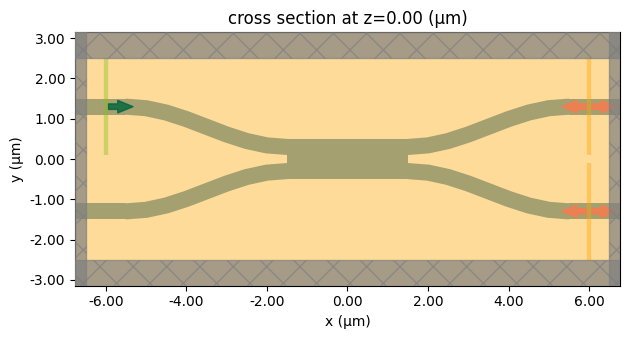

In [8]:
# Simulation Setup Visualization - XY Setup Plane
fig_xy = sim_mmi.plot(z=0)  # XY cross-section at z=0 (MMI center) - shows complete setup

In [9]:
# 3D Visualization
fig_3d = sim_mmi.plot_3d()

## Cost Estimation

Before running the simulation, let's estimate the computational cost.

In [10]:
# Cost Estimation
job = web.Job(simulation=sim_mmi, task_name="mmi_2x2_cost_estimation", verbose=True)
cost_info = web.estimate_cost(job.task_id)
print(f"Estimated cost: {cost_info:.4f} Flex Credits")

10:26:33 Eastern Standard Time Created task 'mmi_2x2_cost_estimation' with      
                               task_id                                          
                               'fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=448041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=283918;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\taskId]8;;\
                               ]8;id=448041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\=]8;;\]8;id=828959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\fdve]8;;\]8;id=448041;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\-3bf02b4c-d20c-4b4e-97ef-5921a3844e93']8;;\.

                               Task folder: ]8;id=895532;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

10:26:37 Eastern Standard Time Maximum FlexCredit cost: 0.077. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

                               Maximum FlexCredit cost: 0.077. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

Estimated cost: 0.0774 Flex Credits


## Run Simulation

Now we run the simulation to obtain the results.

In [11]:
# Run Simulation
sim_data = job.run(path="mmi_2x2_results.hdf5")

10:26:38 Eastern Standard Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

10:26:51 Eastern Standard Time status = preprocess

10:26:55 Eastern Standard Time starting up solver

                               running solver

Output()

10:27:01 Eastern Standard Time early shutoff detected at 40%, exiting.

                               status = postprocess

Output()

10:27:04 Eastern Standard Time status = success

10:27:06 Eastern Standard Time View simulation result at                        
                               ]8;id=762784;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=725736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\taskId]8;;\
                               ]8;id=762784;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\=]8;;\]8;id=443647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\fdve]8;;\]8;id=762784;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3bf02b4c-d20c-4b4e-97ef-5921a3844e93\-3bf02b4c-d20c-4b4e-97ef-5921a3844e93']8;;\.

Output()

10:27:10 Eastern Standard Time loading simulation from mmi_2x2_results.hdf5

## Result Analysis

Let's analyze the simulation results to evaluate the MMI power splitter performance.

**Key Performance Metrics:**

- **Power Splitting Ratio**: The fraction of total power that goes to each output port. For an ideal 2x2 MMI power splitter, both outputs should have a splitting ratio of 0.5 (50/50 split).

- **Total Power**: The sum of power from both output ports, showing the overall transmission efficiency of the device.

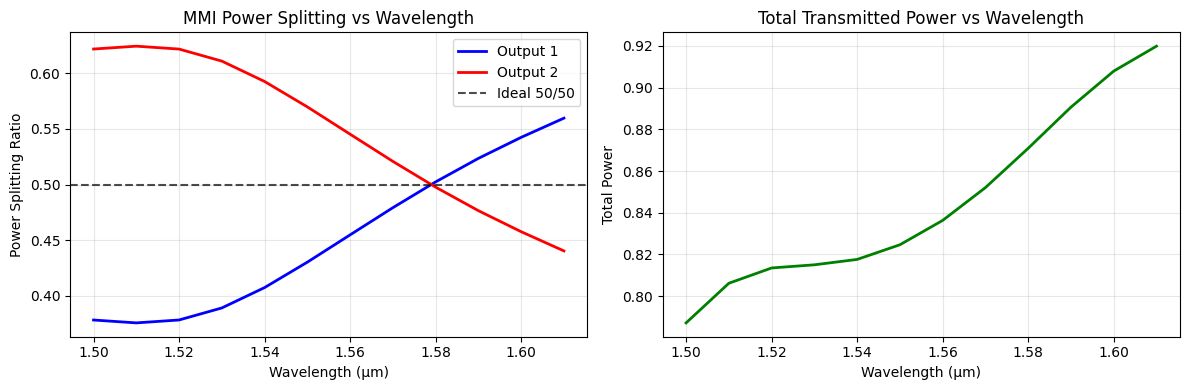

Average splitting ratio 1: 0.452
Average splitting ratio 2: 0.548
Average total power: 0.845


In [12]:
# Extract mode coefficients from ModeMonitors
mode_coeff_1 = sim_data["mode_output_1"].amps.sel(mode_index=0, direction="+")
mode_coeff_2 = sim_data["mode_output_2"].amps.sel(mode_index=0, direction="+")

# Calculate power splitting
power_1 = np.abs(mode_coeff_1) ** 2
power_2 = np.abs(mode_coeff_2) ** 2
total_power = power_1 + power_2

# Calculate splitting ratio
splitting_ratio_1 = power_1 / total_power
splitting_ratio_2 = power_2 / total_power

# Ensure arrays are numpy arrays for consistent indexing
splitting_ratio_1 = np.array(splitting_ratio_1)
splitting_ratio_2 = np.array(splitting_ratio_2)
total_power = np.array(total_power)

# Create comprehensive analysis plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Power splitting vs wavelength
ax1.plot(wavelengths, splitting_ratio_1, "b-", label="Output 1", linewidth=2)
ax1.plot(wavelengths, splitting_ratio_2, "r-", label="Output 2", linewidth=2)
ax1.axhline(y=0.5, color="k", linestyle="--", alpha=0.7, label="Ideal 50/50")
ax1.set_xlabel("Wavelength (μm)")
ax1.set_ylabel("Power Splitting Ratio")
ax1.set_title("MMI Power Splitting vs Wavelength")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Total power vs wavelength
ax2.plot(wavelengths, total_power, "g-", linewidth=2)
ax2.set_xlabel("Wavelength (μm)")
ax2.set_ylabel("Total Power")
ax2.set_title("Total Transmitted Power vs Wavelength")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key performance metrics
print(f"Average splitting ratio 1: {splitting_ratio_1.mean():.3f}")
print(f"Average splitting ratio 2: {splitting_ratio_2.mean():.3f}")
print(f"Average total power: {total_power.mean():.3f}")

**Power Splitting Performance Analysis:**

The power splitting ratio plot reveals several important characteristics of the MMI power splitter:

- **Optimal Operating Wavelength**: The device achieves perfect 50/50 splitting at approximately 1.58 μm, where both output curves intersect the ideal 50/50 line.

- **Wavelength Dependence**: The splitting ratio shows significant wavelength dependence:
  - At shorter wavelengths (1.50 μm): Output 2 receives ~62% of power, Output 1 receives ~37%
  - At longer wavelengths (1.60 μm): Output 1 receives ~54% of power, Output 2 receives ~46%

- **Design Implications**: This wavelength dependence is typical for MMI devices and can be optimized by adjusting the MMI length, width, or using apodization techniques for broader bandwidth performance.

## Field Intensity Analysis

Finally, let's examine the field intensity distribution at specific wavelengths in the XY plane to understand the light propagation through the MMI.

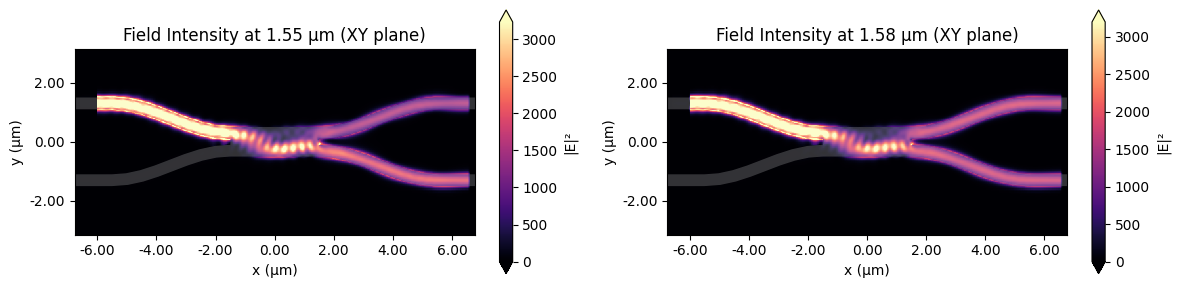

In [13]:
# Create a 2x1 subplot for the two wavelengths.
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Plot field intensity at 1.55 um using Tidy3D's built-in method.
sim_data.plot_field("field_xy", "E", val="abs^2", f=td.C_0 / 1.55, ax=axes[0])
axes[0].set_title("Field Intensity at 1.55 μm (XY plane)")

# Plot field intensity at 1.58 um using Tidy3D's built-in method.
sim_data.plot_field("field_xy", "E", val="abs^2", f=td.C_0 / 1.58, ax=axes[1])
axes[1].set_title("Field Intensity at 1.58 μm (XY plane)")

plt.tight_layout()
plt.show()